# Simulated Example 2
We should consider an example where the underlying graph structure also changes. Perhaps we could have an example: consider temperature on the earth as a function $T:[0,a] \rightarrow \mathbb{S}^2 \times \mathbb{R}.$ Suppose that the temperature is a periodic function, and it is observed around the world at random spots everyday. Hence, at each time, we get a network whose topology approximates that of the sphere. Its points have values determined by the function $T,$ and the edges could represent physical distance. Hence, we have a function that is sampled from a different set of locations at each time, giving rise to a dynamic network where the graph structure changes.

We define a set of sites, a collection of $N$ points on the sphere from which $T$ can be observed. However, the set of sites changes with time - on some measurement periods, only some sites will record data, and some sites will be added / drop out.

# creating graphs on spheres
create graphs on spheres. Go from a collection of points on the sphere to a network. Connect points that are closest to each other - does this give a planar embedding. No.

We instead sample a collection of poitns on the sphere, and compute its delaunay triangulation, which gives a triangulation of this graph on the sphere. We can compute this easily by taking the convex hull on the sphere. We can also fill in the (geodesic) distance between two points using the haversine formula.

In [1]:
import scipy.spatial as sp
from scipy import sparse
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def sample_uniform_sphere(N):
    cds = np.random.normal(0,1,(N,3))
    normalized_cds = cds/np.reshape(np.sqrt(np.sum(cds**2,axis = 1)),(N,1))
    return normalized_cds

<IPython.core.display.Javascript object>


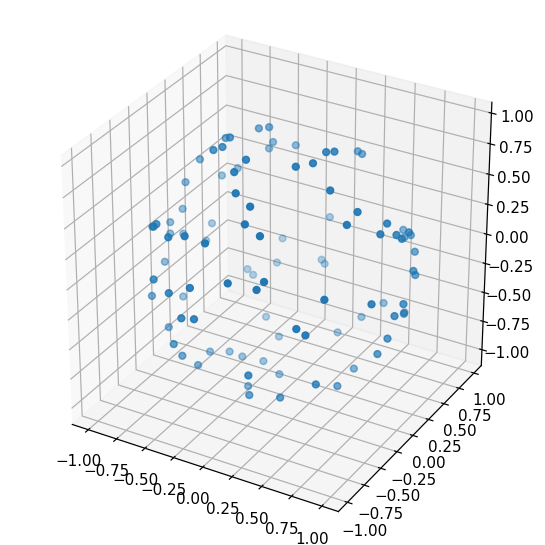

In [2]:
#verify that points are on sphere
points = sample_uniform_sphere(100)
fig = plt.figure(figsize = (5,5))
ax = Axes3D(fig)

ax.scatter(points[:,0],points[:,1],points[:,2])
plt.show()

<IPython.core.display.Javascript object>


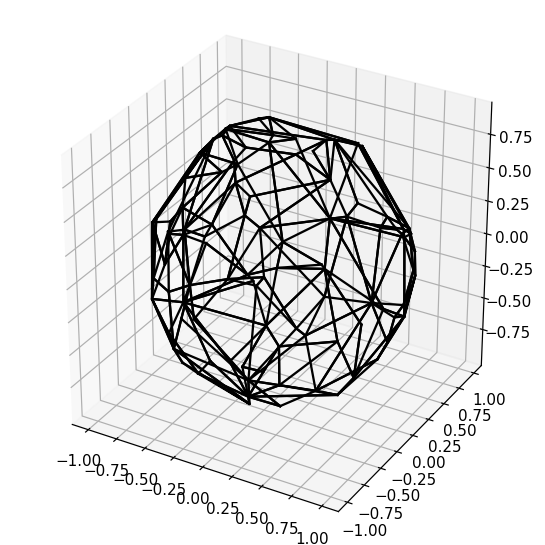

In [3]:
# get the convex hull
hull = sp.ConvexHull(points)

fig = plt.figure(figsize = (5,5))
ax = Axes3D(fig)

for simplex in hull.simplices:
     ax.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], 'k-')
        
plt.show()

In [4]:
# get the adjacency graph of this triangulation
import itertools as itr

def simplex_list_to_adjacency_graph(simplex_list):
    pass

# simplex_list is an array of arrays
def simplex_list_to_edge_list(simplex_list):
    edges = set()
    for simplex in simplex_list:
        simp_edges = set(itr.combinations(simplex,2)) 
        edges = edges.union(simp_edges)
    return edges

In [5]:
# cds should be an array of size (3,)
def cartesian_to_spherical(cds):
    (x,y,z) = cds
    rho = np.sqrt(np.sum(cds**2))
    r = np.sqrt(x**2 + y**2)
    theta = np.arccos(x/r)
    phi = np.arcsin(r/rho)
    
    return (rho,phi,theta)

def cartesian_to_sphere_distance(cds1,cds2):
    (rho,lat1,lon1) = cartesian_to_spherical(cds1)
    (rho,lat2,lon2) = cartesian_to_spherical(cds2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sqrt(np.sin(dlat/2)**2 + np.cos(lat2)*np.cos(lat1)*np.sin(dlon/2)**2)
    c = np.arcsin(a)
    
    return 2*rho*c

In [6]:
# node weights are sampled from a periodic function on the sphere. sin(t + 2*pi*z)?
def periodic_northsouth_modulated(t,cds, T):
    """
    Parameters
    ----------
    t: float
        Time index
    cds: ndarray(N, 3)
        Cartesion coordinates of sphere points
    T: float
        Period of a cycle
    """
    rho, phi, theta = cartesian_to_spherical(cds)
    return 3 + 2*np.cos(2*np.pi*t/T + 2*phi)

def sph_harm_modulated(t,cds, T, m, n):
    """
    A modulated spherical harmonic
    Parameters
    ----------
    t: float
        Time index
    cds: ndarray(N, 3)
        Cartesion coordinates of sphere points
    T: float
        Period of a cycle
    m: int
        m parameter for spherical harmonics
    n: int
        n parameter for spherical harmonics
    """
    from scipy.special import sph_harm
    rho, phi, theta = cartesian_to_spherical(cds)
    return np.sin(2*np.pi*t/T)*np.real(sph_harm(n, m, theta, phi))

def get_node_wts(t,hull_obj, obsfn):
    hull = hull_obj
    node_wts = [obsfn(t,p) for p in hull.points]
    return np.array(node_wts)
    
def get_edge_wts(hull_obj, alpha = 1.0):
    """
    map edges to their distances
    use this to create a dynamic network, edges are these distances.
    Returns
    -------
    edges: scipy.sparse(N, N)
        A sparse matrix with the edge weights
    alpha: float
        Amount by which to weight distances
    """
    hull = hull_obj
    edges = simplex_list_to_edge_list(hull.simplices)
    
    v = hull.points
    ds = [cartesian_to_sphere_distance(v[e[0],:], v[e[1],:]) for e in edges]
    ds = alpha*np.array(ds + ds)
    
    e0 = np.array([e[0] for e in edges] + [e[1] for e in edges])
    e1 = np.array([e[1] for e in edges] + [e[0] for e in edges])
    
    return sparse.coo_matrix((ds, (e0, e1)), shape=(len(v), len(v)))
  
def create_dynamic_network(time_indices, obsfn, edge_wtsfn, change_param = 3, seed = 0):
    """
    Create a sphere network where points are deleted and added at each step
    Parameters
    ----------
    time_indices: ndarray(M)
        Times at which to sample the observation function
    obsfn: function: (t, ndarray(N, 3)) -> ndarray(N)
        An observation function for points on the sphere
    change_param: int
        The maximum number of points to add or delete at each 
        point in time
    seed: int
        Random seed for repeatable results
    """
    np.random.seed(seed)
    node_wts = []
    edge_wts = []
    
    # generate random set of points initially
    points = sample_uniform_sphere(100)
    allpoints = []
    
    # create networks for each time step
    total_removed = 0
    for t in time_indices:
        
        # replace a random set of the points
        num_del = np.random.randint(change_param+1)
        num_ins = np.random.randint(change_param+1)
        total_removed += num_del
        points = update_points(points, num_del, num_ins)
        
        hull = sp.ConvexHull(points)
        node_wts.append(get_node_wts(t,hull, obsfn))
        edge_wts.append(edge_wtsfn(hull))
        allpoints.append(points)
    print("Total Removed: %i"%total_removed)
    return (node_wts,edge_wts,allpoints)

def update_points(pt_list,num_del,num_ins):
    if len(pt_list) + num_ins - num_del <= 0:
        raise Exception('result has non positive length')
    
    new_points = sample_uniform_sphere(num_ins)
    # Remove from the beginning of the list so that gradually
    # all initial points get removed
    return np.concatenate((pt_list[num_del::, :] , new_points), 0)

## Run the dynamic network analysis

In [7]:
from __future__ import division
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import squareform
sys.path.append('../shared_scripts/')
import graph_fns as gf
import persistence_fns as pf
import sliding_window_fns as sw
from ripser import ripser, plot_dgms
from sklearn import manifold

In [8]:
# change edge weights to constants
#edge_wts = np.ones((len(edge_wts),edge_wts[0].shape[0]))

In [9]:
def inverse_x_phi_fn(x):
    return np.array([1/(a + 0.1) for a in x])

def linear_phi_fn(x):
    return np.array([10-a for a in x])

def apply_pipeline(node_wts, edge_wts, d, tau):
    
    # apply phi functions, and scale the weights
    phi_node_wts, phi_edge_wts = gf.weight_fn(node_wts, edge_wts, lamda=1, phi=linear_phi_fn)

    # constrcut the filtrations / simplicial complexes according to our construction
    filtration_matrix = list(map(lambda n, e: pf.get_filtration(n, e), phi_node_wts, phi_edge_wts))
    # summarize these filtrations using H_0 barcodes
    barcodes = list(map(pf.get_rips_complex, filtration_matrix))

    # get bottleneck distance between all the H0 diagrams;
    bn_dist_matrix = pf.get_bottleneck_dist_matrix(barcodes)
    
    # construct a sliding window embedding
    sw_vecs_indices = sw.sliding_window(range(len(barcodes)), d=d, tau=tau)
    sw_dist_matrix = sw.sw_distance_matrix(sw_vecs_indices, bn_dist_matrix)

    # get H1 from the sliding window distance matrix
    PDs = ripser(sw_dist_matrix, distance_matrix=True, maxdim=1, coeff=2)['dgms']
    
    return PDs


In [10]:
def get_maximum_persistence(PD):
    num_dim = len(PD)

    #has to be a 2D array
    def max_pers(array): 
        if len(array) == 0:
            return 0
        diff = array[:,1] - array[:,0]
        return max(diff)

    return list(map(max_pers,PD))

# gets the difference between the persistences of the first and second top features
def get_top_diff_persistence(PD):
    num_dim = len(PD)
    
    def get_diff(array):
        if len(array) == 0:
            return 0
        diff = array[:,1] - array[:,0]
        sorted_diff = sorted(diff,reverse = True)
        if len(sorted_diff) == 1:
            return sorted_diff[0]
        else:
            return sorted_diff[0] - sorted_diff[1]
        
    return(list(map(get_diff,PD)))
        
def get_num_features(PD):
    return(list(map(len,PD)))

Total Removed: 103


<IPython.core.display.Javascript object>


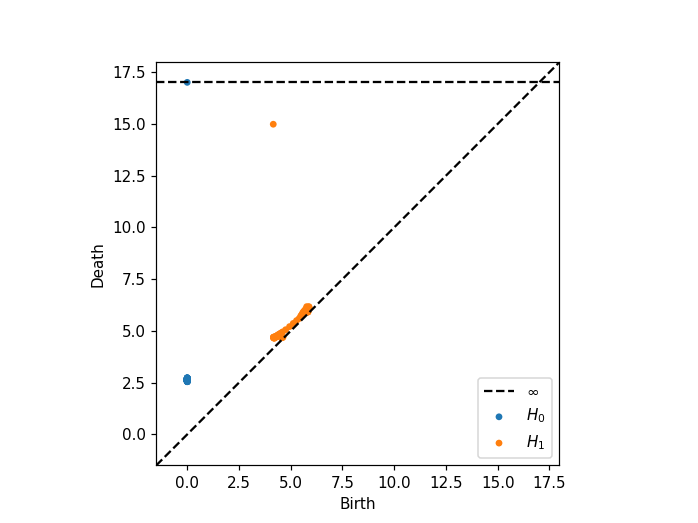

In [13]:
## Setup Dynamic Network
ts = np.arange(200)
T = 60 # Period 
change_param = 1
obsfn = lambda t, p: periodic_northsouth_modulated(t,p,T)
edge_wtsfn = lambda hull_obj: get_edge_wts(hull_obj, alpha = 1.0)
(node_wts,edge_wts, allpoints) = create_dynamic_network(ts, obsfn=obsfn, edge_wtsfn=edge_wtsfn, change_param=change_param)

## Make a video of the evolving sphere
# Step 0: Compute persistence diagrams
# apply phi functions, and scale the weights
phi_node_wts, phi_edge_wts = gf.weight_fn(node_wts, edge_wts, lamda=1, phi=linear_phi_fn)

# constrcut the filtrations / simplicial complexes according to our construction
filtration_matrix = list(map(lambda n, e: pf.get_filtration(n, e), phi_node_wts, phi_edge_wts))
# summarize these filtrations using H_0 barcodes
barcodes = list(map(pf.get_rips_complex, filtration_matrix))

# Step 1: Figure out dynamic range of observation function
xs = []
for nw in node_wts:
    xs += nw.tolist()
xs = np.array(xs)
nmin = np.min(xs)
nmax = np.max(xs)
plt.figure(figsize=(18, 6))
for i, (pts, nw, dgm) in enumerate(zip(allpoints, phi_node_wts, barcodes)):
    plt.clf()
    ax = plt.gcf().add_subplot(121, projection='3d')
    pts = np.concatenate((pts, np.zeros((2, 3))), 0)
    nw = np.concatenate((nw, np.array([nmin, nmax])))
    p = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=nw, s=100, cmap=plt.get_cmap("magma"))
    plt.colorbar(p)
    hull = sp.ConvexHull(pts)
    for simplex in hull.simplices:
         ax.plot(pts[simplex, 0], pts[simplex, 1], pts[simplex, 2], 'k-')
    plt.title("Timestep %i"%i)
    plt.subplot(122)
    plot_dgms(dgm, labels=['H0'])
    plt.title("%i Nodes, %i Dots"%(nw.shape[0]-2, dgm.shape[0]))
    plt.savefig("%i.png"%i, bbox_inches='tight')

PDs = apply_pipeline(node_wts, edge_wts, d = 60, tau = 1) # get the PDs
plt.figure()
plot_dgms(PDs, show=False)
plt.show()

In [ ]:
tau_test_values = range(1,10)
dim_test_values = range(2,10)

mpers_results = np.zeros((len(tau_test_values),len(dim_test_values)))
top_diff_results = np.zeros((len(tau_test_values),len(dim_test_values)))

for tau in tau_test_values:
    for d in dim_test_values:
        print(tau,d)
        
        PDs = apply_pipeline(node_wts,edge_wts, d = d, tau = tau) # get the PDs
        res = (get_maximum_persistence(PDs)[1],get_top_diff_persistence(PDs)[1], get_num_features(PDs)[1])
        print(res)
        
        mpers_results[tau - min(tau_test_values),d - min(dim_test_values)] = res[0]
        top_diff_results[tau - min(tau_test_values),d - min(dim_test_values)] = res[1]

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.gcf().clear()
fig, axs = plt.subplots(2,1, figsize = (7,7))

im1 = axs[0].imshow(mpers_results)

axs[0].set_xlabel('dimension')
axs[0].set_xticks(np.arange(len(dim_test_values)))
axs[0].set_xticklabels(labels = list(dim_test_values))

axs[0].set_ylabel('tau')
axs[0].set_yticks(np.arange(len(tau_test_values)))
axs[0].set_yticklabels(labels = list(tau_test_values))

axs[0].set_title('Max Pers.')

divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1,cax1,orientation = 'vertical')

### Do the other plot ###

im2 = axs[1].imshow(np.divide(top_diff_results,mpers_results),cmap = plt.cm.magma)

axs[1].set_xlabel('dimension')
axs[1].set_xticks(np.arange(len(dim_test_values)))
axs[1].set_xticklabels(labels = list(dim_test_values))


axs[1].set_ylabel('tau')
axs[1].set_yticks(np.arange(len(tau_test_values)))
axs[1].set_yticklabels(labels = list(tau_test_values))
axs[1].set_title('Ratio of Pers. Diff. vs. Max Pers.')

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2,cax2)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle('Max Persistence vs. tau and d', fontsize = 15)
plt.savefig('sphere_Maxpers_and_ratio_change=%i_remove_old_pts' %change_param)
plt.show()

